In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

### read in all trades files and concate to one dataframe
from analysis import single_trade_files_to_one
single_trade_files_to_one().to_csv("historic_data/trades.csv")

### transform trades to usable profits dataframe
from analysis import format_trades_df, get_trade_count, calculate_profits
nft_trades = pd.read_csv("historic_data/trades.csv", low_memory=False)
nft_trades.pipe(format_trades_df).pipe(get_trade_count).pipe(calculate_profits).to_csv("historic_data/profits.csv")

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from analysis import *
from sklearn.cluster import KMeans

In [3]:
nft_trades = load_nft_trades()
get_counts(nft_trades)

Collections: 89, 
Trades: 272978, 
Unique NFTs: 164195


# Create NFT Index

In [4]:
# Profit per day
nft_trades["profit_usd_per_day"] = nft_trades["profit_usd"] / (
    1 + nft_trades["holding_period"]
)

# Get Floor Price per collection per day
floor_price_collections = (
    nft_trades[["sell_date", "sell_price_usd", "collection"]]
    .pivot_table(
        columns="collection", index="sell_date", values="sell_price_usd", aggfunc="min"
    )
    .fillna(0)
)

# Daily market cap
collection_turnover_sum = (
    nft_trades[["sell_date", "sell_price_usd", "collection"]]
    .pivot_table(
        columns="collection", index="sell_date", values="sell_price_usd", aggfunc="sum"
    )
    .fillna(0)
)

# Daily profit per day
collection_profit_per_day = (
    nft_trades[["sell_date", "profit_usd_per_day", "collection"]]
    .pivot_table(
        columns="collection",
        index="sell_date",
        values="profit_usd_per_day",
        aggfunc="sum",
    )
    .fillna(0)
)

# Daily rel market cap per collection
collection_rel_mkt_cap = collection_turnover_sum.div(
    collection_turnover_sum.sum(axis=1), axis=0
)

nft_index_collections = collection_rel_mkt_cap * floor_price_collections
nft_index = pd.DataFrame(nft_index_collections.mean(axis=1), columns=["nft_index"])
nft_index = nft_index / nft_index.iloc[0]["nft_index"]

In [5]:
spx = pd.read_csv("historic_data/spx.csv")
spx = spx.assign(Date=pd.to_datetime(spx.Date)).set_index("Date")

In [6]:
eth_usd = pd.read_csv("historic_data/eth_usd.csv")
eth_usd = eth_usd.assign(Date=pd.to_datetime(eth_usd.Date)).set_index("Date")

In [7]:
eth_usd

,ETH_in_USD
Date,
2019-05-01,160.82
2019-05-02,162.12
2019-05-03,167.95
2019-05-04,164.03
2019-05-05,163.45
...,...
2022-10-04,1362.13
2022-10-05,1352.84
2022-10-06,1351.71


<AxesSubplot: xlabel='Date'>

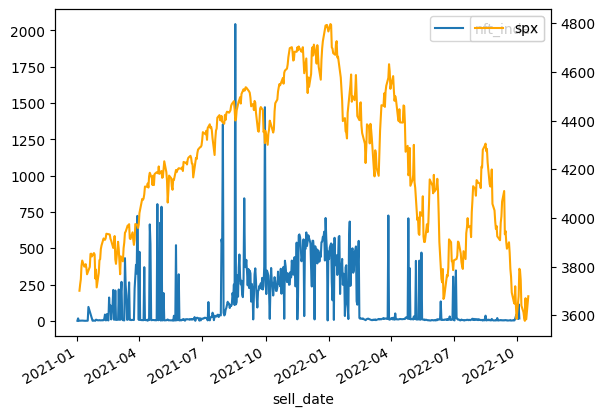

In [8]:
nft_index_plot = nft_index.loc["2021-01-01":]
spx_plot = spx.loc["2021-01-01":]
ax = (nft_index_plot / 1).plot()
ax1 = ax.twinx()
(spx_plot / 1).plot(ax=ax1, color="orange")

In [9]:
matrix = (
    nft_index_plot.merge(spx_plot, how="left", left_index=True, right_index=True)
    .merge(eth_usd, how="inner", left_index=True, right_index=True)
    .rename(
        columns={"nft_index": "NFT Index", "spx": "S&P 500", "ETH_in_USD": "ETH Price"}
    )
)
correl_matrix = matrix.corr()

In [10]:
matrix

,NFT Index,S&P 500,ETH Price
2021-01-01,0.281545,NaN,730.37
2021-01-02,16.846190,NaN,774.53
2021-01-03,0.374130,NaN,975.51
2021-01-08,1.512898,3824.68,1224.20
2021-01-11,0.480327,3799.61,1090.15
...,...,...,...
2022-09-30,45.395037,3585.62,1327.98
2022-10-01,26.766365,NaN,1311.64
2022-10-02,13.278629,NaN,1276.09
2022-10-03,114.024013,3678.43,1323.44


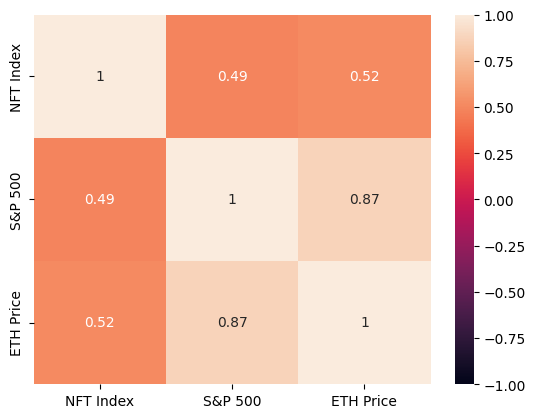

In [11]:
plot_correl_heatmap(correl_matrix)

# Analyse NFT Trades

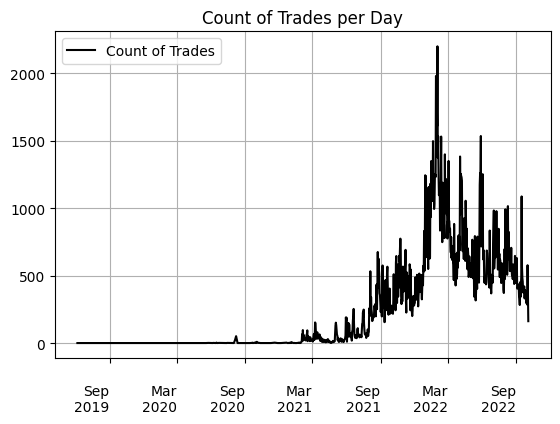

In [12]:
plot_count_trades_per_day(nft_trades)

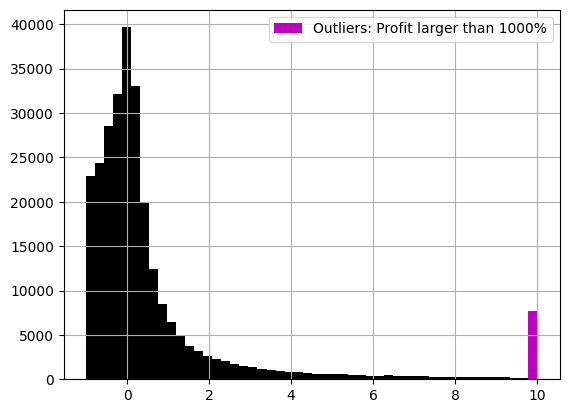

In [13]:
outlier_aware_hist(nft_trades["profit_usd"], -1, 10)

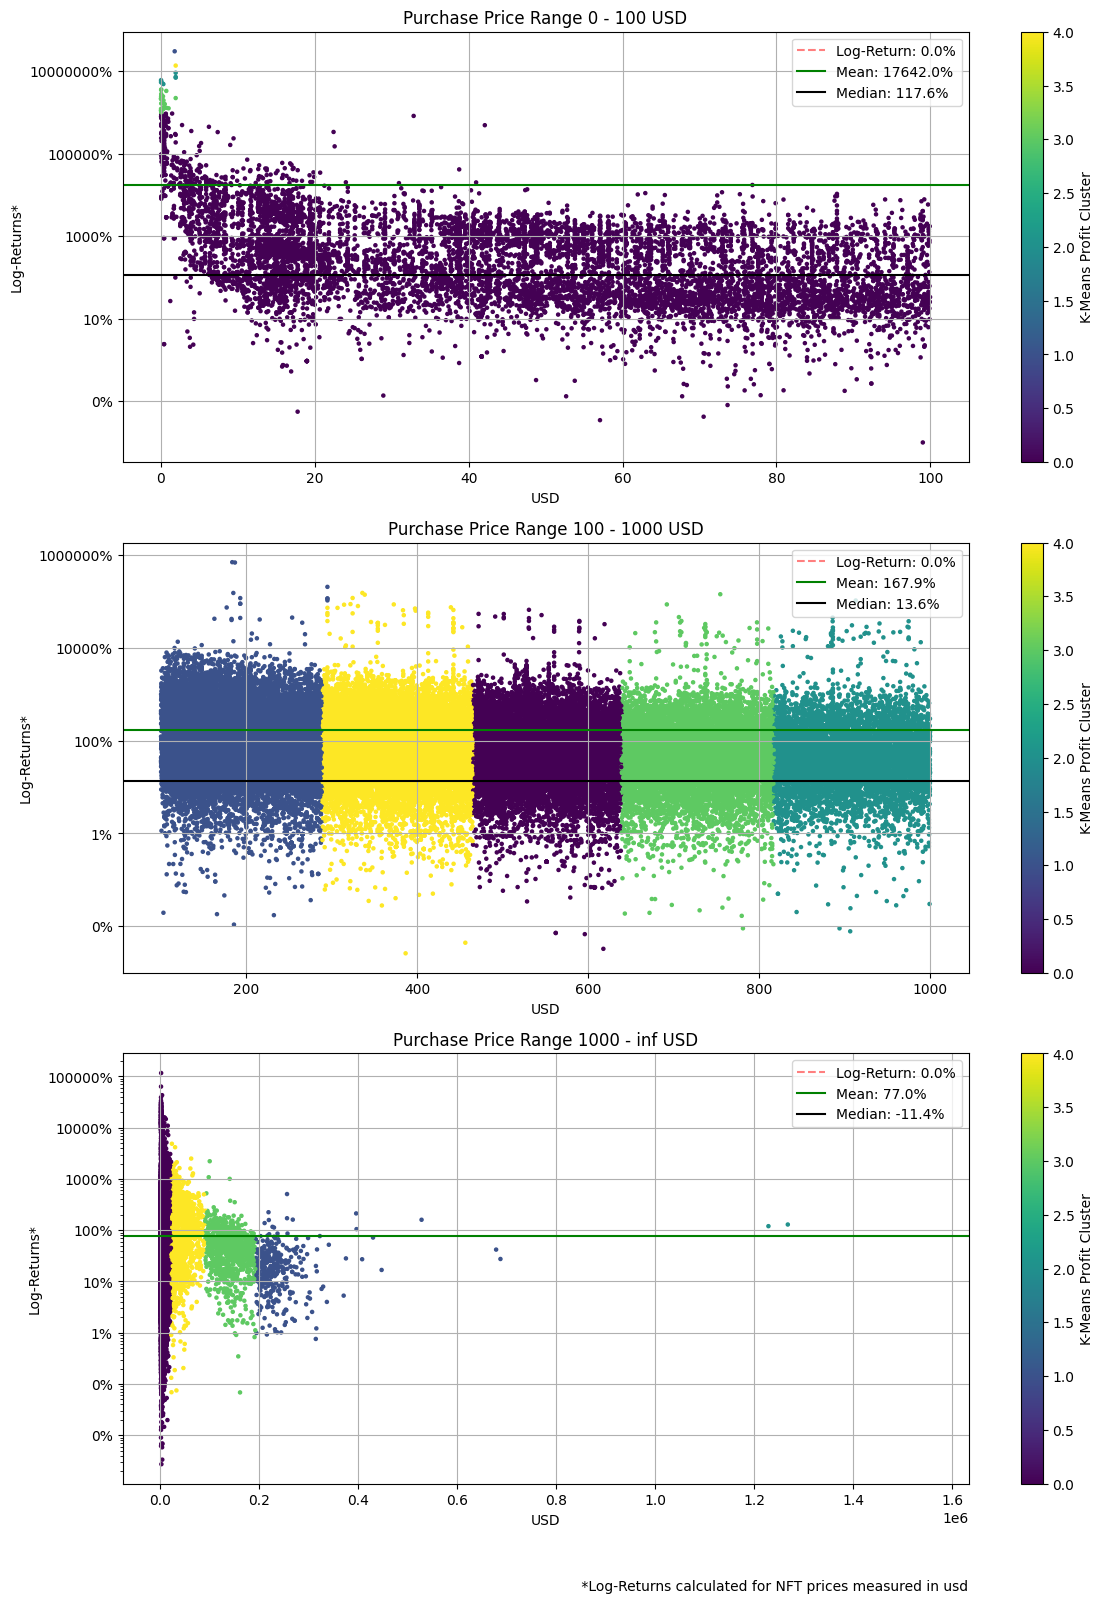

In [16]:
splits = [100, 1000, np.inf]
currency = "usd"

plot_figure_profit_per_price(splits, currency, nft_trades)

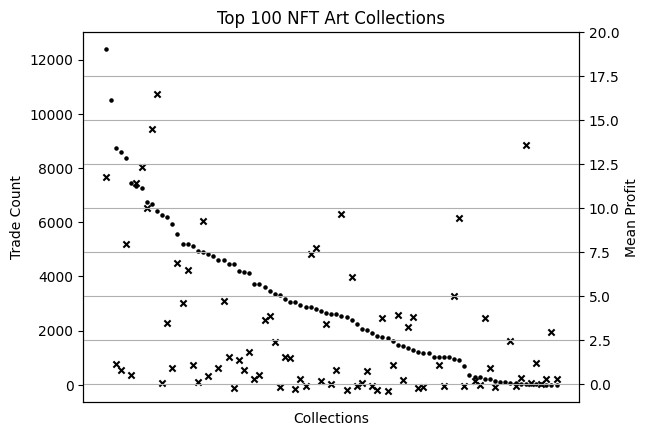

In [40]:
address_grouped = (
    nft_trades[["collection", "profit_usd"]]
    .groupby("collection")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    .head(100)
)

ax = address_grouped.plot.scatter(
    x="collection",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Collections",
)

ax1 = ax.twinx()

address_grouped.plot.scatter(
    x="collection",
    y="mean",
    xticks=[],
    xlabel="Collections",
    color="black",
    ylabel="Mean Profit",
    title="Top 100 NFT Art Collections",
    legend=True,
    secondary_y=True,
    marker="x",
    ylim=(-1, 20),
    ax=ax1,
)
plt.grid()
plt.savefig("figures/profit_per_collection.png")
plt.show()

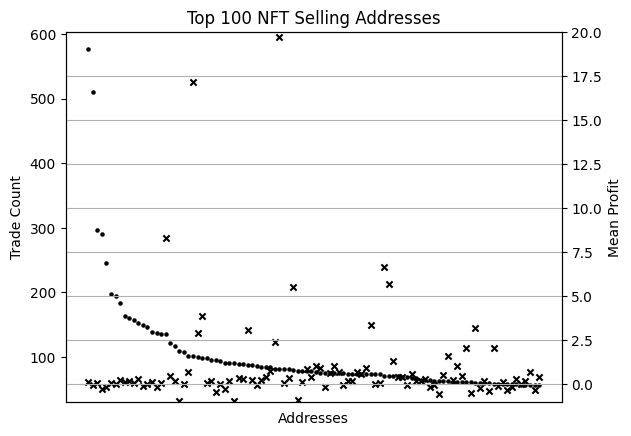

In [42]:
address_grouped = (
    nft_trades[["from_address", "profit_usd"]]
    .groupby("from_address")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    .head(100)
)

ax = address_grouped.plot.scatter(
    x="from_address",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Addresses",
)

ax1 = ax.twinx()

address_grouped.plot.scatter(
    x="from_address",
    y="mean",
    color="black",
    xticks=[],
    xlabel="Addresses",
    ylabel="Mean Profit",
    title="Top 100 NFT Selling Addresses",
    marker="x",
    legend=True,
    secondary_y=True,
    ylim=(-1, 20),
    ax=ax1,
)
plt.grid()
plt.savefig("figures/profit_per_investor.png")
plt.show()

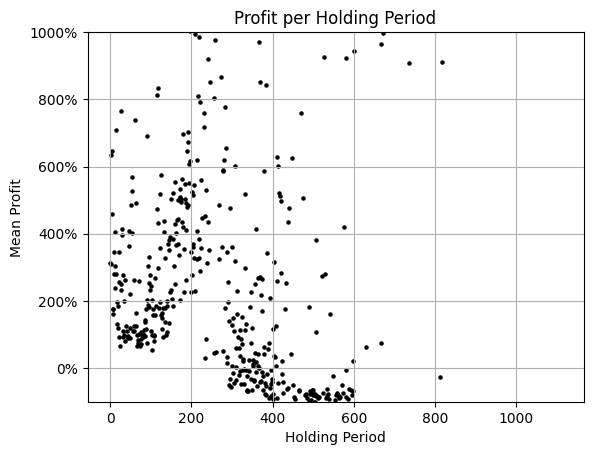

In [35]:
plot_df = (
    nft_trades[["holding_period", "profit_usd"]]
    .groupby("holding_period")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .reset_index()
)
# y_pred = KMeans(5, n_init=100, max_iter=1000, algorithm="elkan")
# y_pred.fit(plot_df[["mean"]])
# plot_df["Cluster"] = y_pred.labels_.astype(float)
ax = plot_df.plot.scatter(
    x="holding_period",
    y="mean",
    # c="Cluster",
    xlabel="Holding Period",
    color="Black",
    ylabel="Mean Profit",
    title="Profit per Holding Period",
    grid=True,
    ylim=[-1, 10],
    marker=".",
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#### ToDo:

- Liquidität
- Erwerbbarkeit
- Handlichkeit der Wallets (Usability)
- Erwartete Rendite vs Vola
- Steuern
- Kosten Gas Fees --> always below 0.001 USD
- Diversifikation innerhalb NFTs -> Korrelationsmatrix

# Get Collections for Appendix

In [43]:
collections_to_latex(nft_trades)

"\\begin{tabular}{lll}\n\\toprule\n{} &                                                 1 &                                         2 \\\\\n\\midrule\n0  &                                        0xmons.xyz &                                 Killer GF \\\\\n1  &                                             10KTF &                         Kitty Crypto Gang \\\\\n2  &                                          3Landers &                   KnownOriginDigitalAsset \\\\\n3  &                                             8SIAN &                                Lil Heroes \\\\\n4  &                                       AIMoonbirds &                            Lives of Asuna \\\\\n5  &                                     AVASTAR Token &                                Lost Poets \\\\\n6  &                          Anatomy Science Ape Club &  MAX PAIN AND FRENS OPEN EDITION BY XCOPY \\\\\n7  &                                             ArtAI &                     MOAR by Joan Cornella \\\\\n8  &     